# Stock Market Analysis and Portfolio Optimization

This project will conduct analysis on stock market and discuss about what strategies are the best to optimize our portfolio values. In the future I will be using machine learning techniques to build a model to optimize the portfolio value. Currently, this project is in an exploratory stage when I am conducting general analysis on each of the stock. 

**Important Note**: All the charts are displayed as a static image for demostrating purposes on Github. All functionalities (e.g. zooming in, showing data on hover, etc.) are **disabled** due to a PNG format. You would need to run locally if you'd like to enable these features.

In [26]:
import pandas as pd
import yfinance as yf
import time
import matplotlib.pyplot as plt
import numpy as np
import technical_indicators as ti
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import plotly.io as pio
from IPython.display import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from trainer import learner


In [2]:
# common methods to get daily return and to normalize the data using pandas

def get_daily_return(data):
    return data / data.shift(1) - 1

def normalize(data):
    return data / data.iloc[0]


In [3]:
#stocks = yf.download('SPY NOK V GLD DIS SBUX AMD MSFT BA TMUS CVX', auto_adjust=True, period='3y') #1y, 5y
# here I use fixed date, please run the code above for the latest dates
stocks = yf.download('SPY NOK V GLD DIS SBUX AMD MSFT BA TMUS CVX', auto_adjust=True, start='2015-01-01',end='2020-01-31')

#stocks = stocks.ffill().bfill()
close = stocks['Close']
spy = close['SPY']
interested_stocks = close.drop(['SPY'], axis=1)

[*********************100%***********************]  11 of 11 completed


Note that stocks = stocks.ffill().bfill() would be needed if we were looking way back in time when a particular stock no longer exist / hadn't existed during that time. 

We begin this project be calculating the daily return for all the stocks.

In [4]:
dailyReturn = get_daily_return(interested_stocks)
dailyReturn = dailyReturn.iloc[1:, :]

dailyReturnSPY = get_daily_return(spy)
dailyReturnSPY = dailyReturnSPY.iloc[1:]

## Stocks Exploratory Analysis

Visualizing the cumulative return for all the stocks for the past three years. Note that all of them started from 1.0. If they doubled the value during the time, then their cumulative return would be 2.0. 

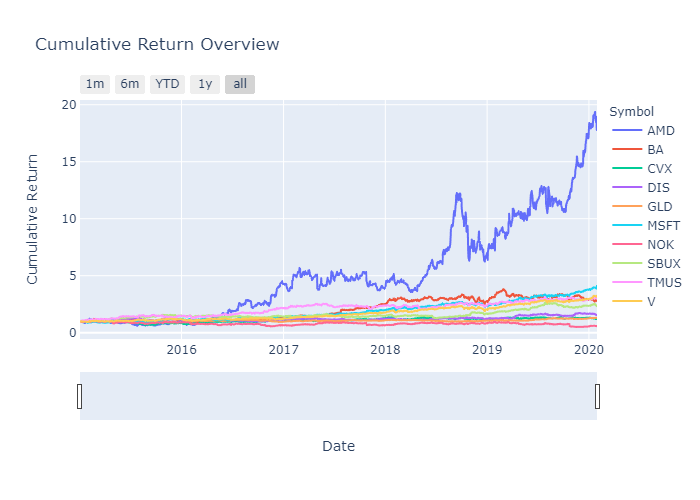

In [5]:
normalizedStocks = normalize(interested_stocks)
fig1 = px.line(normalize(interested_stocks), 
               labels={"value":"Cumulative Return", 'variable': 'Symbol'},
               title='Cumulative Return Overview' )

fig1.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")])))
fig1.show()
Image(pio.to_image(fig1, format='png'))

**Important Note**: All the charts are displayed as a static image for demostrating purposes on Github. All functionalities (e.g. zooming in, showing data on hover, etc.) are disabled due to a PNG format. You would need to run locally if you'd like to enable these features.

Please remove "Image(pio.to_image(fig1, format='png'))" if you do not need the static image. 

We can visualize the correlation between two stocks. Positive Correlation means that when stock A rises, stock B also rises. In contrast, negative corrlation means that when stock A rises, stock B falls. Note that the correlation between oneself is always 1.0.

The heatmap shown below indicates that most stocks has a moderate positive correlation (at 0.5). Specifically, GLD has a weak correlation for all other stocks; Visa (V) and Microsoft (MSFT) has a high positive correlation (>0.8).

Selecting stocks with high correlation might not be optimal for our portfolio. So we might not want to include both Visa and Microsoft.  

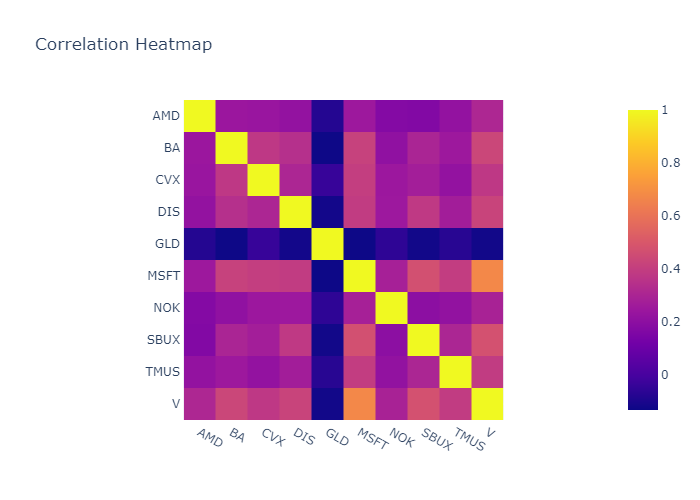

In [6]:
correlations = dailyReturn.corr()

fig = px.imshow(correlations, title='Correlation Heatmap')
fig.show()
Image(pio.to_image(fig, format='png'))

The chart below shows that the return of a stock (y-axis) and the risk associated with it (x-axis). The best spot in the top left portion of the chart, where it would have a high return but low risk. 

According to the chart, AMD has the highest return out of all stocks, but also the most risky. Microsoft (MSFT), Visa (V), T-mobile (TMUS), starbucks (SBUX), and Disney (DIS) all have a similar level of risk, but Microsoft (MSFT) has the highest return in general. As a result, if an investor were to choose a stock to invest in out of these five stocks, Microsoft would be the best out of all. 

## Portfolio Optimization

However, average investor would not solely invest in one stock. A diversified portfolio is often the most important strategy in terms of long term investment. Therefore, we need to search for the best weights for each of the stock in order to find the best position where it generates a high return while keeping the risk as minimal as possible. Therefore, efficient frontier and sharpe ratio kicks in for this purpose. 

In [7]:
stds = dailyReturn.std().rename('std')
means = dailyReturn.mean().rename('mean')

fig = px.scatter(x=stds,  y=means, 
                 color=means.index, text=means.index,
                 labels={"x":"Risk", 'y': 'Return'} )

unseen = 30

mu = expected_returns.mean_historical_return(interested_stocks[:-unseen], frequency=252)
S = risk_models.sample_cov(interested_stocks[:-unseen], frequency=252)

ef = EfficientFrontier(mu, S)
ef.max_sharpe()
w = ef.clean_weights()
w = pd.Series(w)

fig.add_trace(
    go.Scatter(
        x=[(stds * w).sum()], y=[(means * w).sum()],
        mode='markers', marker_symbol='x', marker_size=15, marker_color='blue',
        text=['Best Sharpe Ratio']
    ))

fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.show()

print ('Best weight allocation:')
print (w)
ef.portfolio_performance(verbose=True)

Image(pio.to_image(fig, format='png'))
w = w[w!=0]

Best weight allocation:
AMD     0.10988
BA      0.10570
CVX     0.00000
DIS     0.00000
GLD     0.31806
MSFT    0.21309
NOK     0.00000
SBUX    0.11361
TMUS    0.10848
V       0.03118
dtype: float64
Expected annual return: 24.3%
Annual volatility: 13.8%
Sharpe Ratio: 1.62


## NEED CHANGE
Efficient frontier is a curve where it shows you where the highest return is given the risk level. Not that I am not showing the efficient frontier in the chart above, but showing a point of efficient frontier where it generates the highest sharpe ratio.

Sharpe Ratio is used to help investor determine the return of an investment compared to its risk. With the stocks I selected, it shows that a combination of AMD, GLD, and MSFT generate the highest Sharpe Ratio. 

Looking at the weights, we can see a combination of AMD, BA, GLD, MSFT, SBUX, TMUS, and V. In reality, it is best to invest your portfolio using the weights above. However for illustration and simplicity, let's assume we are seeing roughly 65% from GLD, 25% comes from MSFT, and 10% from AMD. 

GLD is considered a safe stock, where the return is small but the risk is also minimal. MSFT is considered a medium risky stock, but it generates a higher return than GLD. AMD, lastly, is a very risky stock as it's volatility is high. A 65%/25%/10% is a reasonable strategy for an average investor that wants a "okay" return with minimal risk.

We will continue to investigate these three stocks below. 

## Moving Average Convergence Divergence (MACD)

The first indicator I will discuss in this project is Moving Average Convergence Divergence (MACD). Moving Average Convergence Divergence (MACD) is a momentum indicator that utilize a short-term moving average (typically 12 days), a long-term moving average (typically 26 days), and a signal line in order to create a buy or a sell signal. 

Since MACD is a comparison between the short-term moving average and the long-term moving average, it can track how rapid the stock changes. When MACD crosses zeros, it generally means that there is a change of direction of the momentum. When MACD is positive, it means there is a upward momentum; when it is negative, it means the stock is heading down.

Additionally, a 9-day moving average of MACD is also plotted in order to determine when to buy or sell the stock. There is a buying opportunity when the MACD line crosses and is above the signal line; a selling opportunity when the MACD line crosses and is below the signal line.



In [8]:
bestStocks = interested_stocks[w.index]
bestStocksHigh = stocks['High'][w.index]
bestStocksLow = stocks['Low'][w.index]

#bestStocks = interested_stocks[['GLD','MSFT','AMD']]
macd = ti.macd(bestStocks, 12, 26)
signal_line = macd.ewm(span=9, adjust=False, ignore_na=False).mean()


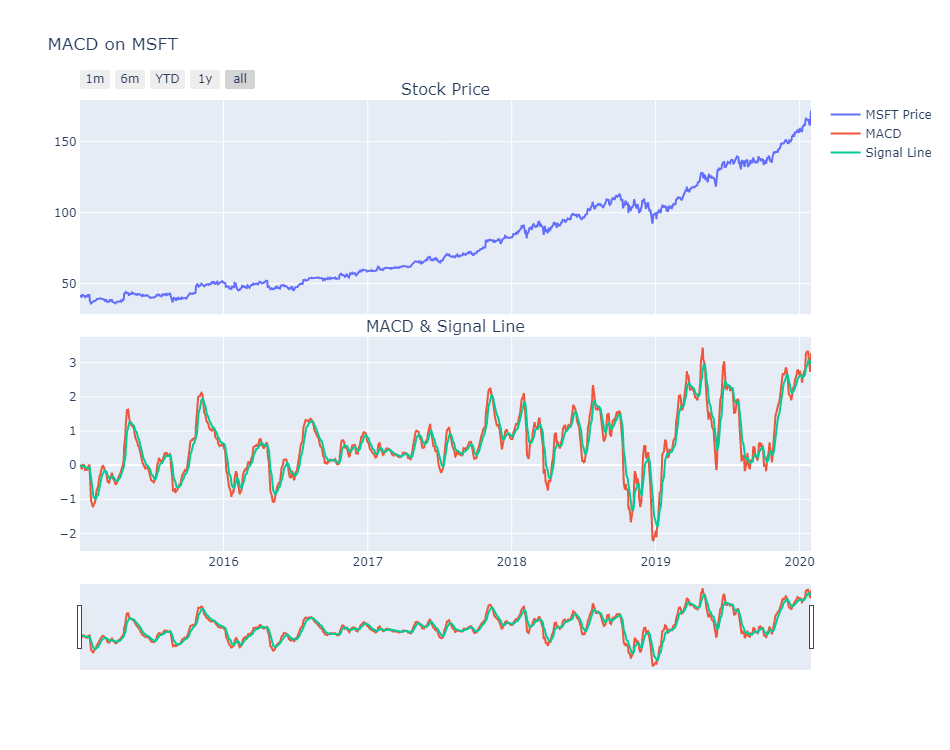

In [9]:

def plot_MACD(symbol, data, macd, signal_line):
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.05, 
                        subplot_titles=("Stock Price", "MACD & Signal Line"))

    top_plot = go.Scatter(x = data[symbol].index, y = data[symbol].values, name=symbol + " Price")

    macd_sym = macd[symbol]
    signal_sym = signal_line[symbol]
    bottom_plot_1 = go.Scatter(x = macd_sym.index, y = macd_sym.values, name='MACD')
    bottom_plot_2 = go.Scatter(x = signal_sym.index, y = signal_sym.values, name='Signal Line')

    fig.append_trace(top_plot, row=1, col=1)
    fig.append_trace(bottom_plot_1, row=2, col=1)
    fig.append_trace(bottom_plot_2, row=2, col=1)

    fig.update_layout(height=750, width=950, title_text="MACD on "+ symbol)

    fig.update_xaxes(row=2, col=1, rangeslider_visible=True)
    fig.update_xaxes(
        row=1, col=1,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    return fig

fig = plot_MACD('MSFT', bestStocks, macd, signal_line)
fig.show()
Image(pio.to_image(fig, format='png'))

## Relative Strength Index (RSI)

Relative Strength Index (RSI) is a technical indicator where it calculates the magnitude of the momentum in order to create a buy or a sell signal. RSI ranges from 0 to 100, and it typically fluctuates in between 30 and 70. 

This indicator might work because it signals when the stock is going up or down too rapidly, and believes that it would return back to the less extreme value. Generally, when the score is below 30, the stock is being oversold, or there is a buying opportunity. In contrast, if the score is above 70, it typically means a sell signal is triggered, since the stock is being overbought. 

Note: I was able to vectorize the RSI calculation and increased the efficiency by 

In [10]:
rsi = ti.rsi(bestStocks, look_back_period=14)

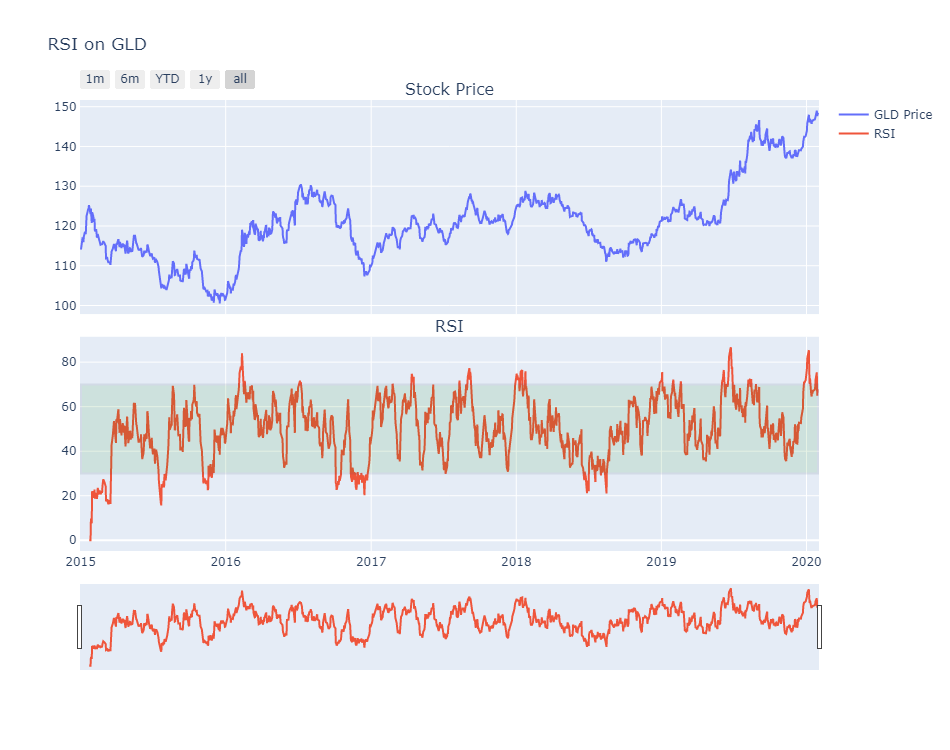

In [11]:
def plot_RSI(symbol, data, rsi):
    rsi_sym = rsi[symbol]
    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=("Stock Price", "RSI"))
    
    top_plot = go.Scatter(x=data[symbol].index, y=data[symbol].values, name=symbol +  ' Price')
    bottom_plot_1 = go.Scatter(x=rsi_sym.index, y=rsi_sym.values, name='RSI')
    fig.append_trace(top_plot, row=1, col=1)
    fig.append_trace(bottom_plot_1, row=2, col=1)
    fig.add_shape(row=2, col=1, type='rect',
                  x0=bestStocks.index [0], y0=70,
                  x1=bestStocks.index[-1], y1=30, 
                  fillcolor='green', 
                  opacity=0.1 )

    fig.update_layout(height=750, width=950, title_text="RSI on " + symbol)

    fig.update_xaxes(row=2, col=1, rangeslider_visible=True)
    fig.update_xaxes(
        row=1, col=1,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])))
    return fig
fig = plot_RSI('GLD',bestStocks, rsi)
fig.show()
Image(pio.to_image(fig, format='png'))

## Average Directional Index (ADX)

Average Directional Index (ADX) is a technical indicator where it tracks the strength of a trend. Typically, if the trend is below 25, the trend is considered weak. Users can use ADX to determine the strength of the trend and decide the best opportunity to buy or to sell a particular stock. 

Note that ADX of 25 is an adjustable threshold. Some people consider ADX of 50 as the strong signal, while some believe 25 is good enough.

ADX alone does not indicate the direction of the trend. Therefore, positive and negative Directional Index, or +-DI, are used to determine whether the stock is uptrend or downtrend. It is considered downtrend if +DI minus -DI is negative. In contrast, it is considered uptrend if +DI minus -DI is positive.

Typically, investors read ADX and +DI minus -DI separately to help them make buying or selling decisions. However, I did a minor twist for the formula attempting to combine these two indicators. In this modified version, the trend would be considered weak if it is between -N and N, where N is the threshold determined by the investor. If ADX was above the positive threshold, then the stock would be considered having a strong and **positive** trend. On the other hand, if ADX was below the negative threshold, the trend would be strong but **negative**.


In [12]:
adx, adx_signal = ti.adx(bestStocks, bestStocksHigh, bestStocksLow, look_back_period=14, modified_version=True)

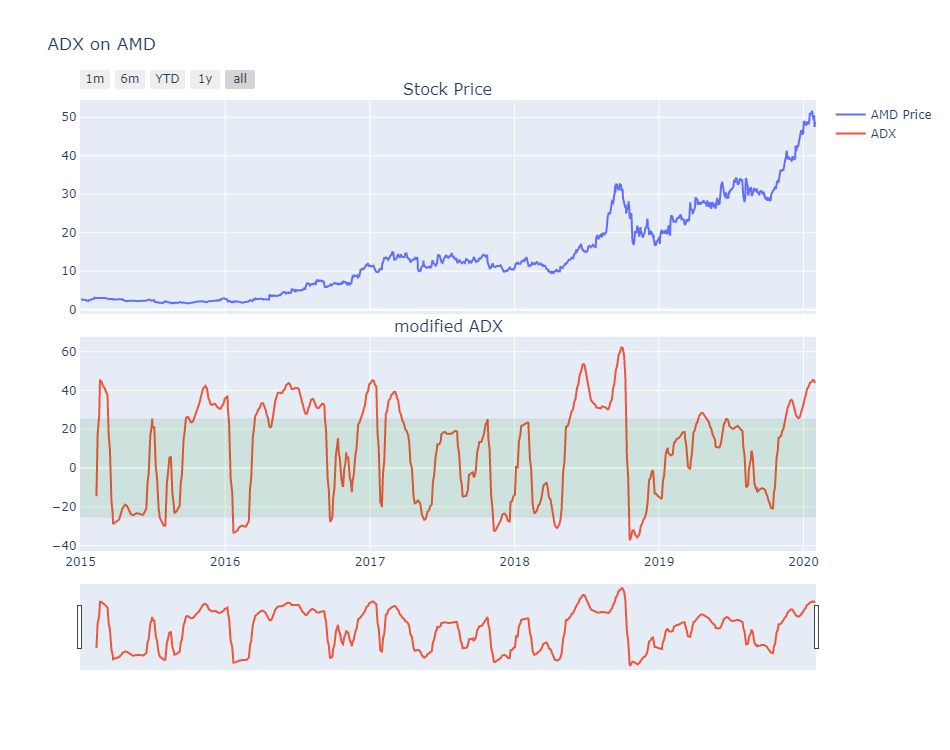

In [13]:
def plot_adx_modified(symbol, data, adx):
    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=("Stock Price", "modified ADX"))

    top_plot = go.Scatter(x=data[symbol].index, y=data[symbol].values, name=symbol + ' Price')
    bottom_plot_1 = go.Scatter(x=adx[symbol].index, y=adx[symbol].values, name='ADX')

    fig.append_trace(top_plot, row=1, col=1)
    fig.append_trace(bottom_plot_1, row=2, col=1)
    fig.add_shape(row=2, col=1, type='rect',
                  x0=bestStocks.index[0], y0=25,
                  x1=bestStocks.index[-1], y1=-25,
                  fillcolor='green',
                  opacity=0.1)

    fig.update_layout(height=750, width=950, title_text="ADX on " + symbol)

    fig.update_xaxes(row=2, col=1, rangeslider_visible=True)
    fig.update_xaxes(
        row=1, col=1,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])))
    return fig

fig = plot_adx_modified('AMD', bestStocks, adx)
fig.show()
Image(pio.to_image(fig, format='png'))

# Tranform a trading problem into a ML problem

Both independent variables and response variables are essential for training a machine learning model. The technical indicators we discussed above will be used as our independent variables. In this section, I will talk about how we can create our own response variable. In other words, this is the core of where I shape a trading problem into a machine learning problem. 

Our response variable will be a categorical variable. Namely, it will tell the investor whether to buy (i.e. long) , to sell (i.e. short), or to hold the current position of a stock in a particular day. 

To create such variable, we need to look into the future (note: we should NEVER look into the future when training our model.) and calculate how much has the stock moved in N-days. If the stock has increased to an extent (above our threshold), then we would consider that day as a buying/selling signal.

For example, assuming we are looking at Jan 01, 2019 and the price is \\$100.00. To create our response variable for this day, we would need to look at the price N-days later, which we can assume N = 3 for now. In Jan 04, the price is \\$105.00. Therefore, the N-days return for this stock would be 0.05. If our threshold is 0.02, then the data point for Jan 01, 2019 would be 'BUY', since 0.05 is greater than the threshold. 

In addition, a new constant called impact is introduced to the problem. Impact is considered as market impact. As investors are basically controlling the price of a stock (they can choose to buy/sell for a particular price), the more shares the investors buy/sell, the more impact they have to the price of the stock. This impact constant is to adjust the effect of the market impact an investor (we) might have made during a trade. In this trading exercise, I am setting this impact as 0. However, if we were going to have some big trades (e.g. billions of dollars), then we might want to adjust this constant.

For days =  1 :
552  signals for  GLD . std =  0.0051
439  signals for  MSFT . std =  0.0119
384  signals for  AMD . std =  0.0372
For days =  3 :
626  signals for  GLD . std =  0.0076
489  signals for  MSFT . std =  0.0186
470  signals for  AMD . std =  0.0519
For days =  5 :
642  signals for  GLD . std =  0.0098
517  signals for  MSFT . std =  0.0225
508  signals for  AMD . std =  0.0599
For days =  7 :
637  signals for  GLD . std =  0.0116
528  signals for  MSFT . std =  0.0245
547  signals for  AMD . std =  0.0632


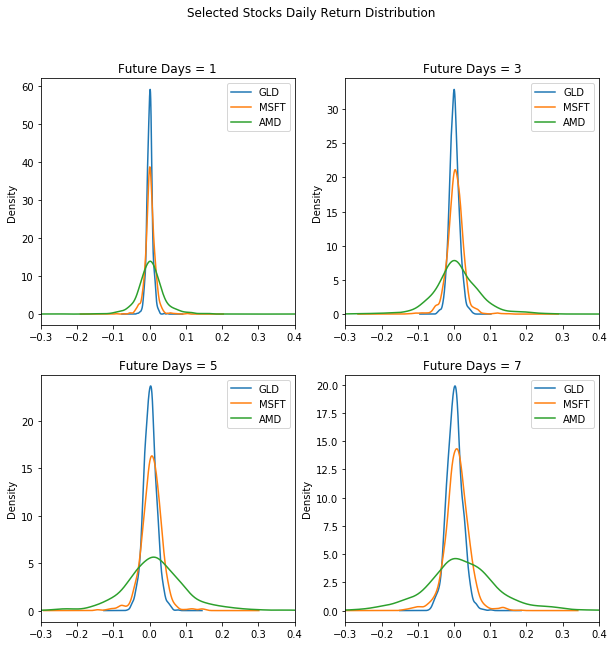

In [15]:
impact = 0

def futureDaysDistribution(selected_stocks, impact=0):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    plt.suptitle("Selected Stocks Daily Return Distribution")
    plt_list = [(0, 0), (0, 1), (1, 0), (1, 1)]
    daysFuture_list = [1, 3, 5, 7]

    for i in range(len(daysFuture_list)):
        daysFuture = daysFuture_list[i]
        priceFuture = selected_stocks.shift(-daysFuture)
        dailyReturnFuture = priceFuture/selected_stocks - 1

        top_left = dailyReturnFuture.plot.kde(ax=ax[plt_list[i]])
        #top_left.set_xlim(dailyReturnFuture.min().min(), dailyReturnFuture.max().max())
        top_left.set_xlim(-.3, .4)
        top_left.set_title("Future Days = " + str(daysFuture))

        pos = dailyReturnFuture - impact > 0
        neg = dailyReturnFuture + impact < 0

        print ('For days = ', daysFuture_list[i], ':')
        for sym in dailyReturnFuture.columns:
            pos_signals = (dailyReturnFuture[sym] > dailyReturnFuture.loc[pos[sym], sym].std())
            neg_signals = (dailyReturnFuture[sym] < dailyReturnFuture.loc[neg[sym], sym].std() * -1)
            print(pos_signals.sum() +
                  neg_signals.sum(),
                  ' signals for ', sym,
                  '. std = ', round((dailyReturnFuture.loc[pos_signals, sym].std() + dailyReturnFuture.loc[neg_signals, sym].std())/2,4)
                  )

futureDaysDistribution(bestStocks[['GLD','MSFT','AMD']])


Back to the example I discussed above. Our 3-days return on Jan 01 is 0.05. We still need to set our threshold in order to create the signal, but how? 

Let's see how the N-days return distributed across these three stocks for different N days, which is shown in the graph above. It is interesting that all of them are bell-shaped. Also, we can see that the relative shape of the three lines are the same across N=1 to N=7. As N increases, the width of the distribution also increases. The wider shape indicates that the difference between each N days are farther apart, which reduces the noise of the price movement. 

Additionally, this graph also tells us how did the stock do during this time period. For GLD and AMD, the means are around 0 (actually slightly above 0). For MSFT, on the other hand, the distribution is shifted to the right as N increases. It means that the price of MSFT is more often to increase than decrease in long term. 

We will be picking our signals based on the distribution above. We are picking the ones that are strong in rising/ dropping over the N-day period. To achieve this, I decided to select only the days that are greater than the standard deviation. As N increases, I expect the number of select days would also increase, since the distribution is wider as N increases. I pick N=5 as my choices, as it generates enough amount of signals, while the standard deviation is larger than the other smaller N.

## Response variable definition

For any day where the future return is greater than the standard deviation of the positive days, then that day would be categorized as 'Buy', or 1 in our y dataset. 

On the otherhand, when the future return is less than the (-1 * standard deviation) of the negative days, then that day would be categorized as 'Sell', or -1 in our y dataset.

All other days would be set as 'Hold', or 0. 

In [16]:
# set up y based on std
daysFuture = 5
priceFuture = bestStocks.shift(-daysFuture)
dailyReturnFuture = priceFuture/bestStocks - 1
y = dailyReturnFuture.copy()
y[:] = 0
for i in y.columns:
    ybuy  = (dailyReturnFuture[i].loc[(dailyReturnFuture[i] - impact) > 0]).std()
    ysell = (dailyReturnFuture[i].loc[(dailyReturnFuture[i] + impact) < 0]).std()
    y[i].loc[dailyReturnFuture[i] >= ybuy] = 1
    y[i].loc[dailyReturnFuture[i] <= ysell*-1] = -1

Let's see how our response variable look like based on the strategy discribed above. Taking GLD as an example: Red vertical lines indicate sell signals, while blue vertical lines indicate buy signals.

(737060.0, 737424.0)

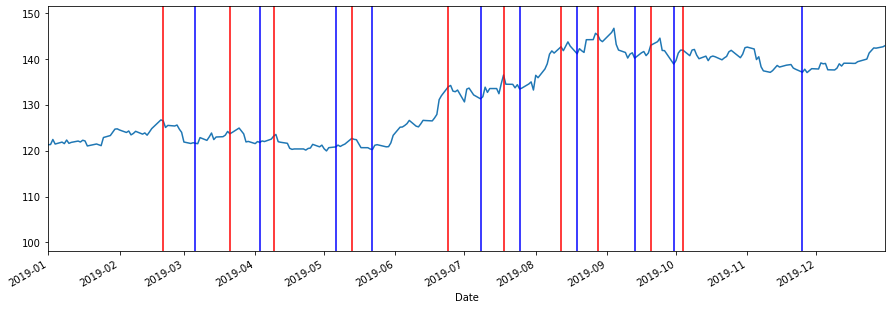

In [17]:
ax = bestStocks['GLD'].plot(figsize=(15,5))
ygld = y['GLD'][y['GLD'] != 0]
ygld[ygld == ygld.shift(1)] = 0
for i in range(len(ygld)):
    if ygld[i] <= -1:
        ax.axvline(ygld.index[i], color = 'red')
    elif ygld[i] >= 1:
        ax.axvline(ygld.index[i], color='blue')
ax.set_xlim('2019-01-01','2019-12-31')

From here, we will need to divide the dataset into stocks, since each stock has it's own buy/sell day. I will use GLD as the illustration. 

First we combine all features as well as the response variable into a single dataframe, because we need to remove any NAN values in the data. These NAN values often appears in the first few days of the data since our technical indicator are not able to calculate the first few values. 

We then split the data into training and testing set. Notice that I am not spliting at random in order to prevent getting insight from the "future". 

In [27]:

def get_all_Xs(sym):
    all_data = pd.concat([macd[sym], rsi[sym], adx[sym], y[sym] ], axis=1)
    # all_data = pd.concat([macd[sym], rsi[sym], adx_v2[sym], y[sym] ], axis=1)
    all_data.columns = ['MACD', 'RSI', 'ADX', 'y']
    all_data.dropna(inplace=True)
    return all_data


models = {}
for i in bestStocks.columns:
    features = get_all_Xs(i)
    unseen_features = features[-unseen:]
    features = features[:-unseen]
    MLmodel = learner(i)
    test_days = int(len(features) / 4)
    MLmodel.load_scale_data(data=features, split_days=test_days)
    MLmodel.grid_search()
    models[i] = [MLmodel, features, unseen_features]
    print('Finished training a model for', i)



[50, 3, 0.013192612137203167, 0.0]
[50, 4, 0.05013192612137203, 0.07079646017699115]
[50, 7, 0.17150395778364116, 0.07692307692307693]
[50, 9, 0.41952506596306066, 0.08461538461538462]
[50, 12, 0.6701846965699209, 0.08461538461538462]
[50, 13, 0.862796833773087, 0.0916030534351145]
[50, 20, 1.0, 0.09929078014184398]


KeyboardInterrupt: 

Before we pass the features to the machine learning model, it is often a good practice to standardize the features before passing it to the models. Note that after we trained it, we need to save the scale and later apply the same scale to the test set. 

In [21]:

def predictionResultToTrading(learner, unseen_data, max_shares = 2000, trade_only = False):
    y = unseen_data.y
    x = unseen_data.drop('y', axis=1)

    unseen_scaled = learner.scaler.transform(x)
    result = learner.rf.predict(unseen_scaled)
    s = pd.Series(result, index=y.index)

    data = s.copy()
    non_zeros = s[s != 0]
    if len(non_zeros) == 0:
        return data
    non_zeros[non_zeros == non_zeros.shift(1)] = 0
    non_zeros = non_zeros * max_shares
    non_zeros[0] /= 2
    data[non_zeros.index] = non_zeros
    if trade_only:
        return non_zeros[non_zeros != 0]
    return data


def generateTrades(models, max_shares):
    all_trades = []
    for i in max_shares.index:
        model = models[i][0]
        unseen_data = models[i][2]
        all_trades.append(predictionResultToTrading(model, unseen_data, max_shares=invest_shares[i]))
    trades = pd.concat(all_trades, axis=1)
    #print (trades)
    trades.columns = max_shares.index
    return trades


def portfolio_value(trades, stock_price, start_val = 100000, impact=0.0):
    holdings = pd.DataFrame(0, index=stock_price.index, columns=stock_price.columns)
    holdings['cash'] = start_val
    market_impact = abs(trades * stock_price) * impact

    yesterday = trades.index[0]
    for date, row in trades.iterrows():
        holdings.loc[date,'cash'] = holdings.loc[yesterday,'cash'] - sum(trades.loc[date,:] * stock_price.loc[date,:]) - sum(market_impact.loc[date,:])
        holdings.loc[date, trades.columns] = holdings.loc[yesterday, trades.columns] + trades.loc[date, :]
        yesterday = date
    return holdings


To find the best number of trees as well as best number of depth for the random forest, I conducted a grid search. The range for the number of trees are 50-210, with an increment of 20; 3 to 21 for the depth. 

For accuracy, due to the unbalanced nature of the response variable. I decided to ignore all the correctly predicted 0s from the result. In other words, rows that are -1, 1 in the Y columns were kept, and rows that were predicted incorrectly are also kept. 

In [20]:
start_val = 100000

invest_shares = start_val * w / bestStocks.iloc[-unseen-1,:]
invest_shares = invest_shares.astype(int)

trades = generateTrades(models=models, max_shares=invest_shares)


                0     1      2    3     4      5     6
Date                                                  
2019-12-17    0.0  16.0    0.0  0.0   0.0    0.0   8.0
2019-12-18    0.0   0.0 -114.0  0.0   0.0    0.0   0.0
2019-12-19    0.0   0.0    0.0  0.0   0.0   71.5   0.0
2019-12-20    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2019-12-23    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2019-12-24  129.5   0.0    0.0  0.0   0.0    0.0   0.0
2019-12-26    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2019-12-27    0.0   0.0    0.0  0.0   0.0 -143.0   0.0
2019-12-30    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2019-12-31    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2020-01-02    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2020-01-03    0.0 -32.0    0.0  0.0   0.0    0.0   0.0
2020-01-06    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2020-01-07    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2020-01-08    0.0  32.0    0.0  0.0   0.0    0.0   0.0
2020-01-09    0.0   0.0    0.0  0.0   0.0    0.0   0.0
2020-01-10

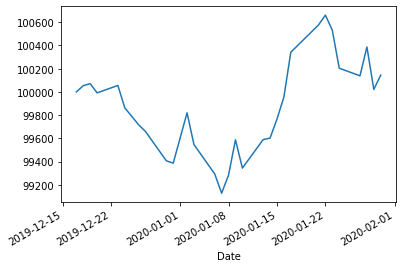

In [24]:

prices = bestStocks.loc[trades.index]
holdings = portfolio_value(trades=trades, stock_price=prices, start_val=100000)
portfolio = holdings['cash'] + (holdings.drop('cash', axis=1) * prices).sum(axis=1)

ax = portfolio.plot()


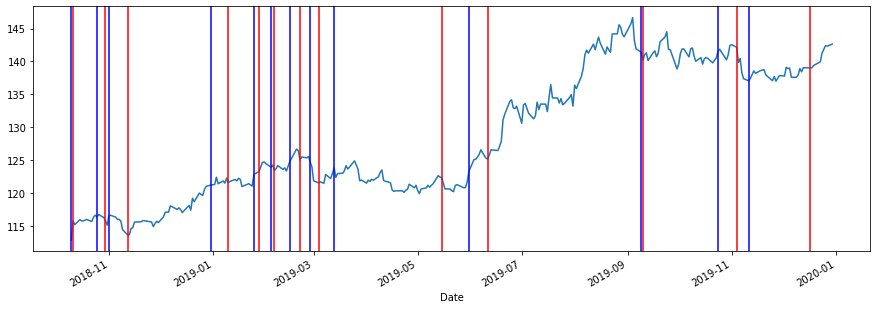

In [37]:
def result_to_trading(s, max_shares = 2000, trade_only = False):
    data = s.copy()
    non_zeros = s[s != 0]
    non_zeros[non_zeros == non_zeros.shift(1)] = 0
    non_zeros = non_zeros * max_shares
    non_zeros[0] /= 2
    data[non_zeros.index] = non_zeros
    if trade_only:
        return non_zeros[non_zeros != 0]
    return data

pred = pd.Series(rf.predict(scaled_test), index=test_x.index)

trades = result_to_trading(pred,trade_only=True)

ax = bestStocks['GLD'].loc[pred.index].plot(figsize=(15,5))
for i in range(len(trades)):
    if trades[i] <= -1:
        ax.axvline(trades.index[i], color = 'red')
    elif trades[i] >= 1:
        ax.axvline(trades.index[i], color='blue')
